In [23]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.interpolate import make_interp_spline, BSpline

In [24]:
#%%file function_definitions.py

    
def output_quadrant(key):
    
    norm_ruu['%s' % key] = norm_ruu['%s' % key] / norm_ruu['%s' % key].max()
    lx = int(len(norm_ruu['%s' % key]['x']) / 2)
    ly = int(len(norm_ruu['%s' % key]['y']) / 2)
    quadrant = norm_ruu['%s' % key][:lx, :ly, :]
    
    return quadrant

#This function is modified to return Xarray instead of Dictionary. 
def read_cbd(file_path):
    '''
    read_cbd: reads the cbd file data
    Arguments:
    file_path-- path where the file is located
    Return--
    xr_data-- data_matrix: 3-D matrix of size (N_x, N_y, N_z)
          x-coord: 1-D array of  x-coordinates size (N_x,1)
          y-coord: 1-D array of  y-coordinates size (N_y,1)
          z-coord: 1-D array of  z-coordinates size (N_z,1)
    '''
    f = open(file_path, "rb")
    id = np.fromfile(f, dtype=np.int64, count=1)[0]
    if id == 288230376151834571:
        T = np.float32
    elif id == 576460752303546315:
        T = np.float64
    else:
        raise ValueError("Invalid ID")
    N = tuple(np.fromfile(f, dtype=np.int64, count=3))
    xmin = tuple(np.fromfile(f, dtype=np.float64, count=3))
    xmax = tuple(np.fromfile(f, dtype=np.float64, count=3))
    x1, x2, x3 = (np.fromfile(f, dtype=np.float64, count=n) for n in N)
    data1 = np.fromfile(f, dtype=T, count=np.prod(N)).reshape(N, order="F")
    xr_data = xr.DataArray(
        data1,
        dims = ("x", "y", "z"),
        coords = { "x" : x1,
                  "y" : x2,
                  "z" : x3
        }   
    )
    f.close()
    return xr_data

def h5_in_xarray(field):
    data = hf.get('%s' % field)
    x1 = hf.get('x-coord')
    x2 = hf.get('y-coord')
    x3 = hf.get('z-coord')
    xr_data = xr.DataArray(
        np.array(data),
        dims = ("x", "y", "z"),
        coords = { "x" : np.array(x1),
                  "y" : np.array(x2),
                  "z" : np.array(x3)
        }   
    )
    
    return xr_data

def create_xarray(u):
    
    # This function creates an xarray that has same data size and coordinates aligned with the input xarray u
    new_array = xr.DataArray(
        np.empty(u.shape),
        dims = ("x", "y", "z"),
        coords = { "x" : u['x'],
              "y" : u['y'],
              "z" : u['z']
        }
    )
    
    return new_array

def intp_w_to_uvp(w, u):
    
    # This function interpolates w to uvp nodes
    w_intp = create_xarray(u)
    w_intp[:, :, :-1] = w.interp(z = u['z'][:-1])
    w_intp[:, :, u['z'].size - 1] = 0
    
    return w_intp

In [25]:
# Let's load the entire data
path = "/Users/erikvanwinkle/Documents/DeSci Labs_files/Marco Node/Node Data/Processed Data"
f = {} # Loads all the variables
h5_files = os.listdir('%s/pressure_corrected_domain_averages' % path)
h5_files_tmp = [match for match in h5_files if "ruu" in match and "_16x" not in match and "_12x" not in match]
h5_files = h5_files_tmp + [match for match in h5_files if "16x48x48" in match and "ruu" in match]
filepath = '%s/pressure_corrected_domain_averages' % path

for sim in h5_files:
    hf = h5py.File('%s/%s' % (filepath, sim), 'r')
    if "l2_16x48x48" in sim or "l4_16x48x48" in sim:
        f['ruu%s' % (sim[8:-3])] = h5_in_xarray('ruu')
    else:
        f['ruu%s' % (sim[8:-3])] = h5_in_xarray('u_rii')

In [26]:
h5_files = os.listdir('%s/pressure_corrected_domain_averages' % path)
h5_files = [match for match in h5_files if "restart0" in match and "_16x" in match and 'ruu' in match and 'run2' not in match]

for sim_ in h5_files:
    pattern = re.search('ruu_chan(_l\d+_\d+x\d+x\d+)_.*', sim_)
    sim = pattern.group(1)
    i = 0
    sim_name = "ruu_chan%s_restart%d.h5" % (sim, i)
    hf = h5py.File('%s/%s' % (filepath, sim_name), 'r')
    f['ruu%s' % (sim)] = h5_in_xarray('u_rii')
    
    for i in range(1, 4):
        sim_name = "ruu_chan%s_restart%d.h5" % (sim, i)
        hf = h5py.File('%s/%s' % (filepath, sim_name), 'r')
        f['ruu%s' % (sim)] += h5_in_xarray('u_rii')

    if "l2_16x48" in sim or "l2_16x72" in sim:
        for i in range(4):
            sim_name = "ruu_chan%s_restart%d_run2.h5" % (sim, i)
            hf = h5py.File('%s/%s' % (filepath, sim_name), 'r')
            f['ruu%s' % (sim)] += h5_in_xarray('u_rii')
        
        f['ruu%s' % (sim)] /= 8
    else:
        f['ruu%s' % (sim)] /= 4

In [27]:
h5_files = os.listdir('%s/longerx_averages' % path)
h5_files = [match for match in h5_files if "restart0" in match and 'ruu' in match and 'run2' not in match and "DS_Store" not in match]
filepath = '%s/longerx_averages' % path
for sim_ in h5_files:
    pattern = re.search('ruu_chan(_l\d+_\d+x\d+x\d+)_.*', sim_)
    sim = pattern.group(1)
    i = 0
    sim_name = "ruu_chan%s_restart%d.h5" % (sim, i)
    hf = h5py.File('%s/%s' % (filepath, sim_name), 'r')
    f['ruu%s' % (sim)] = h5_in_xarray('u_rii')
    
    for i in range(1, 4):
        sim_name = "ruu_chan%s_restart%d.h5" % (sim, i)
        hf = h5py.File('%s/%s' % (filepath, sim_name), 'r')
        f['ruu%s' % (sim)] += h5_in_xarray('u_rii')
        
    f['ruu%s' % (sim)] /= 4

In [28]:
import re

pattern = re.compile(r'\d+') 

In [29]:
# Loading variance data
field_list = ['u', 'v', 'w', 'uu']
h5_files = os.listdir('%s/pressure_corrected_domain_averages' % path)
h5_files_tmp = [match for match in h5_files if "chan" in match and "_16x" not in match and "_12x" not in match and "ruu" not in match and "rvv" not in match and "ruw" not in match]
h5_files = h5_files_tmp + [match for match in h5_files if "16x48x48" in match and "ruu" not in match and "rvv" not in match and "ruw" not in match]
filepath = '%s/pressure_corrected_domain_averages' % path

for sim in h5_files:
    hf = h5py.File('%s/%s' % (filepath, sim), 'r')
    for field in field_list:
        f['%s%s' % (field, sim[4:-3])] = h5_in_xarray(field)
        
h5_files = os.listdir('%s/pressure_corrected_domain_averages' % path)
h5_files = [match for match in h5_files if "restart0" in match and "_12x" not in match and "ruu" not in match and "rvv" not in match and "run2" not in match and "ruw" not in match]
for sim in h5_files:
    sim = re.search('chan(_l\d+_\d+x\d+x\d+).*', sim).group(1)
    i = 0
    sim_name = "chan%s_restart%d.h5" % (sim, i)
    hf = h5py.File('%s/%s' % (filepath, sim_name), 'r')
    for field in field_list:
        f['%s%s' % (field, sim)] = h5_in_xarray(field)
    
    for i in range(1, 4):
        sim_name = "chan%s_restart%d.h5" % (sim, i)
        hf = h5py.File('%s/%s' % (filepath, sim_name), 'r')
        for field in field_list:
            f['%s%s' % (field, sim)] += h5_in_xarray(field)

    if "l2_16x48" in sim or "l2_16x72" in sim:
        for i in range(4):
            sim_name = "chan%s_restart%d_run2.h5" % (sim, i)
            hf = h5py.File('%s/%s' % (filepath, sim_name), 'r')
            for field in field_list:
                f['%s%s' % (field, sim)] += h5_in_xarray(field)
        
        for field in field_list:
            f['%s%s' % (field, sim)] /= 8
    else:
        for field in field_list:
            f['%s%s' % (field, sim)] /= 4

In [30]:
# Loading variance data
field_list = ['u', 'v', 'w', 'uu']
h5_files = os.listdir('%s/longerx_averages' % path)
filepath = '%s/longerx_averages' % path
h5_files = [match for match in h5_files if "restart0" in match and "ruu" not in match and "rvv" not in match and "run2" not in match and "ruw" not in match]
for sim in h5_files:
    sim = sim[4:-12]
    i = 0
    sim_name = "chan%s_restart%d.h5" % (sim, i)
    hf = h5py.File('%s/%s' % (filepath, sim_name), 'r')
    for field in field_list:
        f['%s%s' % (field, sim)] = h5_in_xarray(field)
    
    for i in range(1, 4):
        sim_name = "chan%s_restart%d.h5" % (sim, i)
        hf = h5py.File('%s/%s' % (filepath, sim_name), 'r')
        for field in field_list:
            f['%s%s' % (field, sim)] += h5_in_xarray(field)

    for field in field_list:
        f['%s%s' % (field, sim)] /= 4

In [31]:
# Now, I need to load the uu variance to normalize autocorrelation
h5_files_list = os.listdir('%s/pressure_corrected_domain_averages' % path)
h5_files = [match[4:-3] for match in h5_files_list if "_16x" not in match and "_12x" not in match and "chan" in match and "ruu" not in match and "rvv" not in match and "ruw" not in match]
h5_files_16 = [match[4:-12] for match in h5_files_list if "restart0" in match and "_16x" in match and "ruu" not in match and "rvv" not in match and "run2" not in match and "ruw" not in match]
h5_files += h5_files_16 + [match[4:-3] for match in h5_files_list if "16x48x48" in match and "ruu" not in match and "rvv" not in match and "run2" not in match and "ruw" not in match]
h5_files_longerx = os.listdir('%s/longerx_averages' % path)
h5_files_longerx = [match[4:-12] for match in h5_files_longerx if "restart0" in match and "ruu" not in match and "rvv" not in match and "run2" not in match and "ruw" not in match]
h5_files += h5_files_longerx

var_list = ['uu']
temp = {}

for sim in h5_files:
    for v in var_list:
        temp["%s%s" % (v, sim)] = f["%s%s" % (v, sim)].mean(dim = ['x', 'y']) - (f["%s%s" % (v[0], sim)] * f["%s%s" % (v[1], sim)]).mean(dim = ['x', 'y'])
        
disp = {}

for sim in h5_files:
    for v in var_list:
        disp["%s%s" % (v, sim)] = (f["%s%s" % (v[0], sim)]*f["%s%s" % (v[1], sim)]).mean(dim = ['x', 'y']) - f["%s%s" % (v[0], sim)].mean(dim = ['x', 'y']) * f["%s%s" % (v[1], sim)].mean(dim = ['x', 'y'])
        
stress = {}

for sim in h5_files:
    for v in var_list:
        stress["%s%s" % (v, sim)] = temp["%s%s" % (v, sim)] + disp["%s%s" % (v, sim)]     

In [32]:
key_list = list(f.keys())
key_list = [match[4:] for match in key_list if "ruu" in match]

In [33]:
sims = list(stress.keys())

In [34]:
norm_ruu={}
for key in key_list:
    norm_ruu["%s" % key] = f["ruu_%s" % key] / stress["uu_%s" % key]

In [35]:
def shift_quadrants(xarray):
    shifted_array = np.empty(xarray.shape)
    lx = int(len(xarray['x']) / 2)
    ly = int(len(xarray['y']) / 2)
    
    shifted_array[:lx, :ly, :] = xarray[lx:, ly:, :].values
    shifted_array[lx:, :ly, :] = xarray[:lx, ly:, :].values
    shifted_array[:lx, ly:, :] = xarray[lx:, :ly, :].values
    shifted_array[lx:, ly:, :] = xarray[:lx, :ly, :].values
    
    shifted_x = xarray['x'] - (xarray['x'][-1]) / 2
    shifted_y = xarray['y'] - (xarray['y'][-1]) / 2
    return shifted_array, shifted_x, shifted_y

def contour_ruu_2(key, z_locs, ax):
    pattern = re.compile(r'\d+')
    match = pattern.findall(key)
    
    norm_ruu['%s' % key] = norm_ruu['%s' % key] / norm_ruu['%s' % key].max()
    shifted_norm, shifted_x, shifted_y = shift_quadrants(norm_ruu['%s' % key])
    
    for z in z_locs:
        X, Y = np.meshgrid(shifted_x, shifted_y)
        if "144" not in key:
            CS = ax.contour(X, Y, shifted_norm[:, :, int(z * int(match[1]) * 8)].transpose(), levels=[-0.2, 0, 0.2, 0.4, 0.6, 0.8], vmax=1, vmin=-1, cmap='coolwarm')
        else:
            CS = ax.contour(X, Y, shifted_norm[:, :, int(z * int(match[1]) * 8)].transpose(), levels=[-0.2, 0, 0.2, 0.4, 0.6, 0.8], vmax=1, vmin=-1, cmap='coolwarm')
        plt.clabel(CS, CS.levels, inline=True, fontsize=10, fmt='%.1f', colors = 'k')
        plt.xlabel('x')
        plt.ylabel('y')
    return None

In [36]:
# Computing the spanwise length of the streaks 
from matplotlib import rc
import matplotlib
rc('font',weight='normal',size=11,family='serif',serif='Computer Modern Roman')
rc('text', usetex=True)

plt.style.use('default')
def output_yloc(xarray, z, cutoff_val):
    # This function outputs xloc of cutoff value for a given z
    for i in range(xarray['y'].size):
        if xarray[0, i, z] < cutoff_val:
            break;

    # also calculating residual length (which is smaller than the grid size based on interpolation)
    left_val = xarray[0, i-1, z].values
    right_val = xarray[0, i, z].values
    dr = (xarray['y'][1] - xarray['y'][0]).values
    delta_req   = left_val - cutoff_val
    delta_grid = left_val - right_val
    residual = dr * delta_req / delta_grid 
    return i , residual

def computing_structure_length():
    pack_list = ["l2", "l4", "l6", "l12"]
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    number_of_plots = len(pack_list)
    colormap = plt.cm.Accent  #I suggest to use nipy_spectral, Set1,Paired
    color_list = [colormap(i) for i in np.linspace(0, 1,number_of_plots)]
    color_list = [val for val in color_list for _ in (0, 1)]
    ax1.set_prop_cycle(color=color_list)
    for pack_den in pack_list:
        key_list = ["%s_16x48x96" % pack_den, "%s_16x72x96" % pack_den]
        for key in key_list:
            if "48" in key:
                col = '--'
                legend = r'$\lambda_p = %.3f$, YAR = %.1f' % (1/int(pack_den[1:])**2, 3.0)
            else:
                col = '-'
                legend = r'$\lambda_p = %.3f$, YAR = %.1f' % (1/int(pack_den[1:])**2, 4.5)
            quadrant = output_quadrant(key)
            znodes = quadrant['z'].size
            struc_len = np.empty(znodes)
            dr = (quadrant['y'][1] - quadrant['y'][0]).values

            for i in range(znodes):
                y_loc, residual = output_yloc(quadrant, i, 0)
                struc_len[i] = dr * (y_loc - 1) + residual

            ax1.plot(struc_len[:-1] * 4, quadrant['z'][:-1] / 16, col, label=legend, linewidth=2)
    
    plt.plot(np.ones(50) * 24, np.linspace(0, 1, 50), 'k-.', linewidth=1.5, label="domain width, YAR = 1.5")
    plt.plot(np.ones(50) * 48, np.linspace(0, 1, 50), 'k--', linewidth=1.5, label="domain width, YAR = 3.0")
    plt.plot(np.ones(50) * 72, np.linspace(0, 1, 50), 'k-', linewidth=2, label="domain width, YAR = 4.5")
    plt.xlim((0, 72))
    plt.ylim((0, 1))
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=11)
    fig1.text(0.5, 0.035, 'Domain width', ha='center', va='center', fontsize=11)
    fig1.text(0.06, 0.5, r'$z/L_3$', ha='center', va='center', rotation='horizontal', fontsize=11)
    plt.gca().set_aspect(50)
    fig1.savefig("length_of_streamwise_structures.eps", format="eps", bbox_inches='tight')




### Figure 5

0.4140625 l2 l2_16x48x96
0.3203125 l2 l2_16x72x96
0.1015625 l4 l4_16x48x96
0.15625 l4 l4_16x72x96
0.2109375 l6 l6_16x48x96
0.171875 l6 l6_16x72x96
0.125 l12 l12_16x48x96
0.0234375 l12 l12_16x72x96


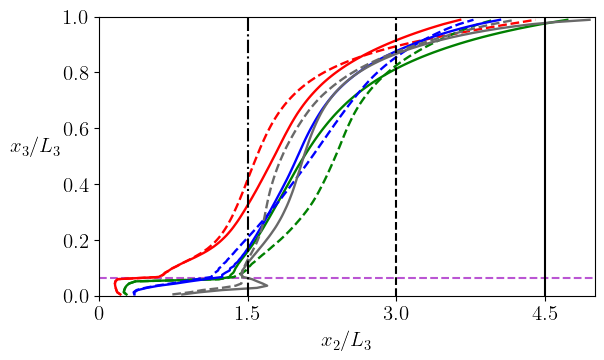

In [37]:
from matplotlib import rc
import matplotlib
rc('font',weight='bold',size=15,family='serif',serif='Computer Modern Roman')
rc('text', usetex=True)

# plt.style.use('default')
def output_yar15(arr):
    # This function outputs at which value the structure length crosses 1.5L_3
    for i in range(arr.size):
        if arr[i] * 4 > 1.5 * 16:
            break;
    return i

def output_yloc(xarray, z, cutoff_val):
    # This function outputs yloc of cutoff value for a given z
    for i in range(xarray['y'].size):
        if xarray[0, i, z] < cutoff_val:
            break;

    # also calculating residual length (which is smaller than the grid size based on interpolation)
    left_val = xarray[0, i-1, z].values
    right_val = xarray[0, i, z].values
    dr = (xarray['y'][1] - xarray['y'][0]).values
    delta_req   = left_val - cutoff_val
    delta_grid = left_val - right_val
    residual = dr * delta_req / delta_grid 
    return i , residual

def computing_structure_length():
    pack_list = ["l2", "l4", "l6", "l12"]
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    number_of_plots = len(pack_list)
    color_list = ['r', 'g', 'b', 'k']
    plt.plot(np.linspace(0, 80, 20), np.ones(20) * 1/16, color='mediumorchid', linestyle='dashed', linewidth=1.5, label='UCL height')
    for index, pack_den in enumerate(pack_list):
        key_list = ["%s_16x48x96" % pack_den, "%s_16x72x96" % pack_den]
        for key in key_list:
            if "48" in key:
                col = '--'
                legend = r'$\lambda_p = %.3f$, YAR = %.1f' % (1/int(pack_den[1:])**2, 3.0)
            else:
                col = '-'
                legend = r'$\lambda_p = %.3f$, YAR = %.1f' % (1/int(pack_den[1:])**2, 4.5)
            quadrant = output_quadrant(key)
            znodes = quadrant['z'].size
            struc_len = np.empty(znodes)
            dr = (quadrant['y'][1] - quadrant['y'][0]).values

            for i in range(znodes):
                y_loc, residual = output_yloc(quadrant, i, 0)
                struc_len[i] = dr * (y_loc - 1) + residual

            zloc = output_yar15(struc_len)

            if color_list[index] != 'k': 
                ax1.plot(struc_len[:-1] * 4, quadrant['z'][:-1] / 16, color_list[index] + col, linewidth=1.7, label=legend)
            elif col == '-': 
                ax1.plot(struc_len[:-1] * 4, quadrant['z'][:-1] / 16, color='dimgrey', linestyle='solid', linewidth=1.7, label=legend)
            else: 
                ax1.plot(struc_len[:-1] * 4, quadrant['z'][:-1] / 16, color='dimgrey', linestyle='dashed', linewidth=1.7, label=legend)
    
    plt.plot(np.ones(50) * 24, np.linspace(0, 1, 50), color='black', linestyle='dashdot', linewidth=1.5, label="domain width, YAR = 1.5")
    plt.plot(np.ones(50) * 48, np.linspace(0, 1, 50), color='black', linestyle='dashed', linewidth=1.5, label="domain width, YAR = 3.0")
    plt.plot(np.ones(50) * 72, np.linspace(0, 1, 50), color='black', linestyle='solid', linewidth=1.5, label="domain width, YAR = 4.5")
    
    plt.xlim((0, 80))
    ax1.set_ylim(0, 1)
    ax1.set_xticks([0, 24, 48, 72])
    ax1.set_xticklabels([0, 1.5, 3.0, 4.5])
    ax1.set_xlabel(r'$x_2/L_3$', fontsize=15)
    ax1.set_ylabel(r'$x_3/L_3$', fontsize=15, rotation=0, labelpad=20)
    for tick in ax1.xaxis.get_majorticklabels():  # example for xaxis
        tick.set_fontsize(15)
    for tick in ax1.yaxis.get_majorticklabels():  # example for xaxis
        tick.set_fontsize(15)
    plt.gca().set_aspect(45)  ###THIS WAS ON FOR RESULTS IN THE PAPER

computing_structure_length()

### Figure 4

In [38]:
def shift_quadrants2(xarray):
    shifted_array = create_xarray(xarray)
    lx = int(len(xarray['x']) / 2)
    ly = int(len(xarray['y']) / 2)
    
    shifted_array[:lx, :ly, :] = xarray[lx:, ly:, :].values
    shifted_array[lx:, :ly, :] = xarray[:lx, ly:, :].values
    shifted_array[:lx, ly:, :] = xarray[lx:, :ly, :].values
    shifted_array[lx:, ly:, :] = xarray[:lx, :ly, :].values
    
    shifted_array['x'] = xarray['x'] - (xarray['x'][-1]) / 2
    shifted_array['y'] = xarray['y'] - (xarray['y'][-1]) / 2
    return shifted_array

In [39]:
def contour_ruu_4(key, z_locs, ax, fs):
    pattern = re.compile(r'\d+')
    match = pattern.findall(key)
    
    norm_ruu['%s' % key] = norm_ruu['%s' % key] / norm_ruu['%s' % key].max()
    shifted_norm, shifted_x, shifted_y = shift_quadrants(norm_ruu['%s' % key])
    
    for z in z_locs:
        X, Y = np.meshgrid(shifted_x, shifted_y)
        if "144" not in key:
            CS = ax.contour(X, Y, shifted_norm[:, :, int(z * int(match[1]) * 8)].transpose(), levels=[-0.2, 0, 0.2, 0.4, 0.6, 0.8], vmax=1, vmin=-1, cmap='coolwarm')
        else:
            CS = ax.contour(X, Y, shifted_norm[:, :, int(z * int(match[1]) * 8)].transpose(), levels=[-0.2, 0, 0.2, 0.4, 0.6, 0.8], vmax=1, vmin=-1, cmap='coolwarm')
        plt.clabel(CS, CS.levels, inline=True, fontsize=fs, fmt='%.1f', colors = 'k')
        plt.xlabel('x')
        plt.ylabel('y')
    return None

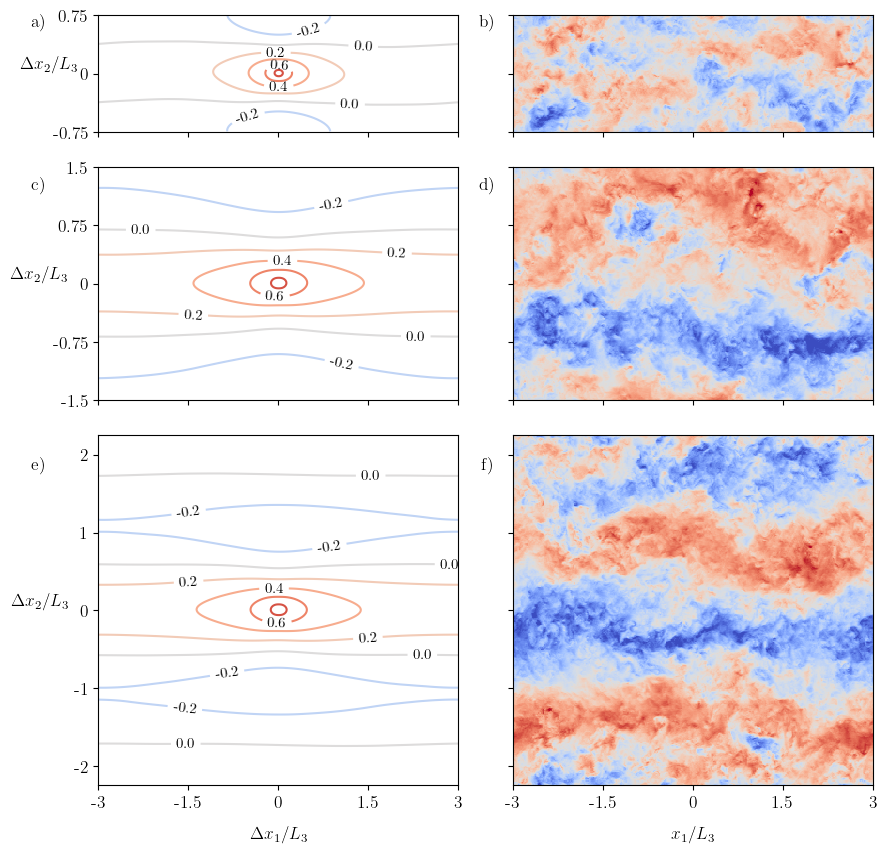

In [42]:
#: Here, I'm trying to plot the same figure above but with different widths of rows.
from matplotlib import rc
import matplotlib
rc('font',weight='bold',size=12.5,family='serif',serif='Computer Modern Roman')
rc('text', usetex=True)

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10), sharex='col', sharey='row', gridspec_kw={'height_ratios': [1, 2, 3]})
spanlist = ["24", "48", "72"]
z_loc = 9.6
pack_den = "l6"

for i in range(3):
    contour_ruu_4('%s_16x%sx96' % (pack_den, spanlist[i]), [0.6], axs[i, 0], 10.75)
    
    axs[i, 0].set_xticks([-48, -24, 0, 24, 48])
    axs[i, 0].set_xticklabels([-3, -1.5, 0, 1.5, 3])
    if i == 0:
        axs[0, 0].set_yticks([-12, -6, 0, 6, 12])
        axs[0, 0].set_yticklabels([-0.75, -0.375, 0, 0.375, 0.75])
        axs[i, 0].set_ylabel(r'$\Delta x_2/L_3$', rotation=0, labelpad=3)
    elif i == 1:
        axs[1, 0].set_yticks([-24, -12, 0, 12, 24])
        axs[1, 0].set_yticklabels([-1.5, -0.75, 0, 0.75, 1.5])
        axs[i, 0].set_ylabel(r'$\Delta x_2/L_3$', rotation=0, labelpad=10)
    else:
        axs[2, 0].set_yticks([-32, -16, 0, 16, 32])
        axs[2, 0].set_yticklabels([-2, -1, 0, 1, 2])
        axs[i, 0].set_xlabel(r'$\Delta x_1/L_3$', rotation=0, labelpad=11)
        axs[i, 0].set_ylabel(r'$\Delta x_2/L_3$', rotation=0, labelpad=25)

cbd_files = ["/Users/erikvanwinkle/Documents/DeSci Labs_files/Marco Node/Node Data/Raw Data/1_u-1000-YAR1_5.cbd",
            "/Users/erikvanwinkle/Documents/DeSci Labs_files/Marco Node/Node Data/Raw Data/2_u-1000-YAR3.cbd",
            "/Users/erikvanwinkle/Documents/DeSci Labs_files/Marco Node/Node Data/Raw Data/3_u-1000-YAR4_5.cbd"]

for i in range(3):
    u = read_cbd(cbd_files[i])
    u_shifted = shift_quadrants2(u)
    (u_shifted[:, :, round(8*z_loc)] - u_shifted[:, :, round(8*z_loc)].mean()).transpose().plot.pcolormesh(ax = axs[i, 1], cmap = 'coolwarm', vmin=-4, vmax=4, add_colorbar=False)
    axs[i, 1].set_title('')
    axs[i, 1].set_xlabel('')
    axs[i, 1].set_ylabel('')
    axs[2, 1].set_xticks([-48, -24, 0, 24, 48])
    axs[2, 1].set_xticklabels([-3, -1.5, 0, 1.5, 3])
    if i == 0:
        axs[0, 1].set_yticks([-12, 0, 12])
        axs[0, 1].set_yticklabels([-0.75, 0, 0.75])
    elif i == 1:
        axs[1, 1].set_yticks([-24, -12, 0, 12, 24])
        axs[1, 1].set_yticklabels([-1.5, -0.75, 0, 0.75, 1.5])
    else:
        axs[2, 1].set_yticks([-32, -16, 0, 16, 32])
        axs[2, 1].set_yticklabels([-2, -1, 0, 1, 2])
        axs[2, 1].set_xlabel(r'$x_1/L_3$', rotation=0, labelpad=11)

namelist = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']
k = 0
for i in range(3):
    for j in range(2):
        if k % 2 == 0:
            plt.text(-0.165, 0.9, namelist[k], horizontalalignment='center', transform=axs[i, j].transAxes,fontsize=12.5)
        else:
            plt.text(-0.07, 0.9, namelist[k], horizontalalignment='center', transform=axs[i, j].transAxes,fontsize=12.5)
        k += 1

plt.subplots_adjust(hspace=0.15, wspace=0.15)

### Figure 7

In [43]:
# Now I need to find out the integral length scale based on quadrant data
def output_quadrant(key):
    
    norm_ruu['%s' % key] = norm_ruu['%s' % key] / norm_ruu['%s' % key].max()
    lx = int(len(norm_ruu['%s' % key]['x']) / 2)
    ly = int(len(norm_ruu['%s' % key]['y']) / 2)
    quadrant = norm_ruu['%s' % key][:lx, :ly, :]
    
    return quadrant

def output_xloc(xarray, z, cutoff_val):
    # This function outputs xloc of cutoff value for a given z
    for i in range(xarray['x'].size):
        if xarray[i, 0, z] < cutoff_val:
            break;
    
    # also calculating residual length (which is smaller than the grid size based on interpolation)
    left_val = xarray[i-1, 0, z].values
    right_val = xarray[i, 0, z].values
    dr = (xarray['x'][1] - xarray['x'][0]).values
    delta_req   = left_val - cutoff_val
    delta_grid = left_val - right_val
    residual = dr * delta_req / delta_grid 
    return i , residual

def calc_L11(xarray, cutoff):
    # Calculating integral length scale for the quadrant
    
    znodes = xarray['z'].size 
    l = np.empty(znodes)
    dr = xarray['x'][1] - xarray['x'][0]

    for i in range(znodes):
        x_loc, residual = output_xloc(xarray, i, cutoff)
        l[i] = np.sum(xarray[:x_loc - 1, 0, i]) * dr.values  + xarray[x_loc - 1, 0, i] * residual
    
    return l

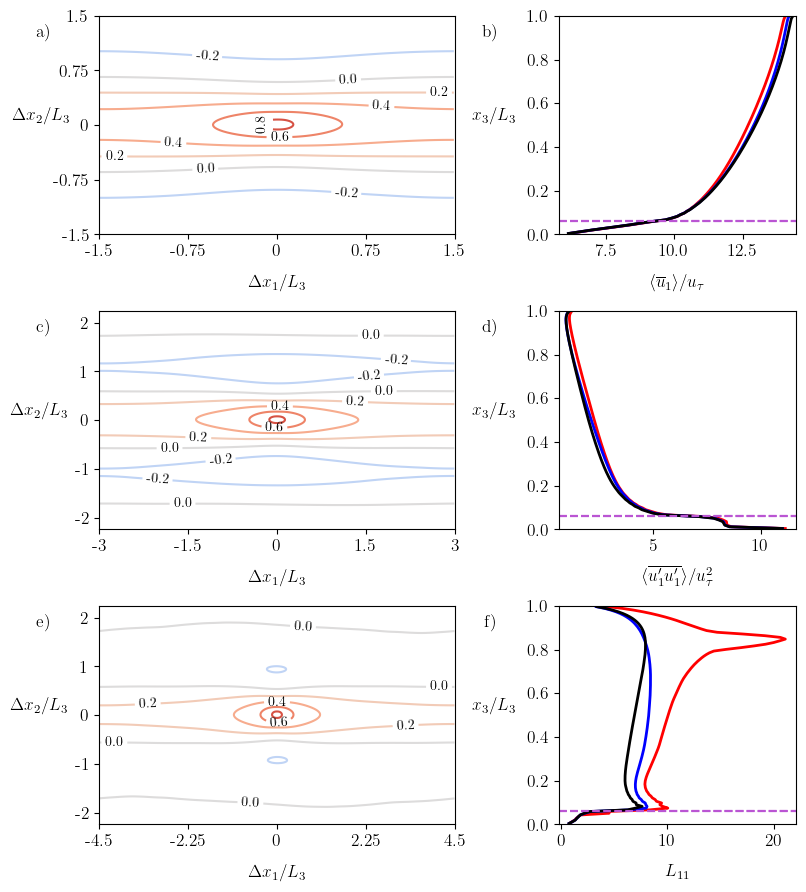

In [44]:
from matplotlib import rc
import matplotlib
rc('font',weight='bold',size=12.5,family='serif',serif='Computer Modern Roman')
rc('text', usetex=True)

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(9, 10.5), gridspec_kw={'width_ratios': [1.5, 1]})
key_list = ["l6_16x48x48", "l6_16x72x96", "l6_16x72x144"]
colorlist = ['r', 'b', 'k']
z_loc = 9.6

for i in range(3):
    contour_ruu_2(key_list[i], [0.6], axs[i, 0])
    axs[i, 0].set_ylabel(r'$\Delta x_2/L_3$', rotation=0, labelpad=26)
    axs[i, 0].set_xlabel(r'$\Delta x_1/L_3$', rotation=0, labelpad=11)
    if i == 0:
        axs[i, 0].set_yticks([-24, -12, 0, 12, 24])
        axs[i, 0].set_yticklabels([-1.5, -0.75, 0, 0.75, 1.5])
        axs[i, 0].set_xticks([-24, -12, 0, 12, 24])
        axs[i, 0].set_xticklabels([-1.5, -0.75, 0, 0.75, 1.5])

    elif i == 1:
        axs[i, 0].set_yticks([-32, -16, 0, 16, 32])
        axs[i, 0].set_yticklabels([-2, -1, 0, 1, 2])
        axs[i, 0].set_xticks([-48, -24, 0, 24, 48])
        axs[i, 0].set_xticklabels([-3, -1.5, 0, 1.5, 3])

    else:
        axs[i, 0].set_yticks([-32, -16, 0, 16, 32])
        axs[i, 0].set_yticklabels([-2, -1, 0, 1, 2])
        axs[i, 0].set_xticks([-72, -36, 0, 36, 72])
        axs[i, 0].set_xticklabels([-4.5, -2.25, 0, 2.25, 4.5])

axs[0, 0].set_ylabel(r'$\Delta x_2/L_3$', rotation=0, labelpad=9, fontsize=12.5)
axs[0, 1].set_xlabel(r'$\langle\overline{u}_1\rangle/u_{\tau}$', rotation=0, labelpad=11, fontsize=12.5)
axs[1, 1].set_xlabel(r'$\langle\overline{u_1^\prime u_1^\prime}\rangle/u_{\tau}^2$', rotation=0, labelpad=8, fontsize=12.5)
axs[2, 1].set_xlabel(r'$L_{11}$', rotation=0, labelpad=11, fontsize=12.5)

for index, key in enumerate(key_list):
    axs[0, 1].plot(f["u_%s" % key].mean(dim=['x', 'y']), f["u_%s" % key]['z'] / 16, colorlist[index], linewidth=2)
    xlimits = axs[0, 1].get_xlim()
    xmax = xlimits[1]
    axs[0, 1].plot(np.linspace(xlimits[0], xlimits[1], 20), np.ones(20) * 1/16, color='mediumorchid', linestyle='dashed', linewidth=1.5, label='UCL height')
    axs[0, 1].set_xlim(xlimits[0], xlimits[1])

    axs[1, 1].plot(stress["uu_%s" % key], f["u_%s" % key]['z'] / 16, colorlist[index], linewidth=2)
    xlimits = axs[1, 1].get_xlim()
    xmax = xlimits[1]
    axs[1, 1].plot(np.linspace(xlimits[0], xlimits[1], 20), np.ones(20) * 1/16, color='mediumorchid', linestyle='dashed', linewidth=1.5, label='UCL height')
    axs[1, 1].set_xlim(xlimits[0], xlimits[1])

    quadrant = output_quadrant(key)
    l11 = calc_L11(quadrant, 0.5)
    axs[2, 1].plot(l11, quadrant['z'] / 16, colorlist[index], linewidth=2)
    xlimits = axs[2, 1].get_xlim()
    xmax = xlimits[1]
    axs[2, 1].plot(np.linspace(xlimits[0], xlimits[1], 20), np.ones(20) * 1/16, color='mediumorchid', linestyle='dashed', linewidth=1.5, label='UCL height')
    axs[2, 1].set_xlim(xlimits[0], xlimits[1])
    

namelist = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']
k = 0
for i in range(3):
    axs[i, 1].set_ylabel(r'$x_3/L_3$', rotation=0, labelpad=24)
    axs[i, 1].set_ylim(0, 1)
    for j in range(2):
        if k % 2 == 0:
            plt.text(-0.155, 0.9, namelist[k], horizontalalignment='center', transform=axs[i, j].transAxes,fontsize=12.5)
        else:
            plt.text(-0.287, 0.9, namelist[k], horizontalalignment='center', transform=axs[i, j].transAxes,fontsize=12.5)
        k += 1

plt.subplots_adjust(hspace=0.35, wspace=0.35)